In [111]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patheffects as PathEffects

plt.rcParams["figure.figsize"] = (6, 4)

labels = ['Spanish', 'Catalan', 'Portugese', 'Thai', 'Average']
a_means = [85, 65, 83, 45]
a_means.append(np.mean(a_means))
b_means = [81, 60, 79, 52]
b_means.append(np.mean(b_means))

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
fig.tight_layout()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
rects1 = ax.bar(x - width/2, a_means, width, label='Method A', color='darkblue')
rects2 = ax.bar(x + width/2, b_means, width, label='Method B', color='darkred')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Performance')
ax.set_xticks(x)
ax.set_xticklabels(labels)


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, -15),
                    textcoords="offset points",
                    ha='center', va='bottom', color='white')


autolabel(rects1)
autolabel(rects2)

ax.legend()

plt.savefig('fig1.pdf', bbox_inches='tight')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

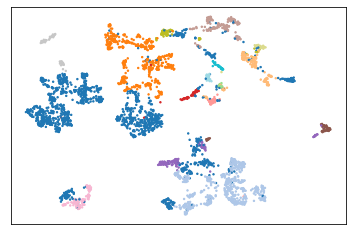

In [42]:
from uriel import Uriel
u = Uriel(load=True, umap=True)

In [134]:
plt.rcParams["figure.figsize"] = (9,3)
from papers import papers



xs = np.mean(scores, axis=0)        
ys = np.mean(scores[
    [i
     for i, l
     in enumerate(languages)
     if not u.is_in_family(l, ['Slavic', 'Germanic', 'Italic'])
    ]
], axis=0)
fig, axes = plt.subplots(1, 3)
plt.subplots_adjust(wspace=0.1)

axes[0].scatter(u.umap_vectors.embedding_[:,0], u.umap_vectors.embedding_[:,1],
            c=u.language_metadata(u.uriel_languages)['label'],
            s=1,
            cmap='tab20')
for ax, c in zip(axes, 'abc'):
    ax.set_xticks([])
    ax.set_yticks([])
    eh = ax.set_title(f'({c})', fontsize=7)


rahimi_lang, rahimi_scores = papers['rahimi_ner']
heinzer_lang, heinzer_scores = papers['heinzerling_pos']

cut = u.umap_vectors.embedding_
cut = cut[cut[:, 0] > 2.5]
cut = cut[cut[:, 1] > 3.5]
cut = cut[cut[:, 1] < 18]

for ax, langs, sc1, sc2 in [[axes[1], rahimi_lang, rahimi_scores[:, 2], rahimi_scores[:, 11]], [axes[2], heinzer_lang, heinzer_scores[:, 0], heinzer_scores[:, 10]]]:
    score1 = dict(zip(langs, sc1))
    score2 = dict(zip(langs, sc2))
    metadata = u.language_metadata(u.uriel_languages)
    metadata = metadata[metadata['code'].isin(langs)]
    diff = {l: score2[l] / score1[l] - 1 for l in metadata['code']}
    metadata = metadata.assign(
    x=u.umap_vectors.embedding_[metadata.index][:,0],
    y=u.umap_vectors.embedding_[metadata.index][:,1],
    width=0.05,
    height=[diff[l] for l in metadata['code']],
    color=['#66ee66' if diff[l] > 0 else '#ee6666' for l in metadata['code']],
    )
    metadata['height'] /= max(metadata['height'])
    metadata['height'] *= 2
    metadata['y'] += metadata['height'] / 2
    
    ax.scatter(cut[:, 0], cut[:, 1], s=1, c=(0.9, 0.9, 0.9))
    for x, y, h in zip(metadata['x'], metadata['y'], metadata['height'],):
        if h > 0:
            ax.plot([x, x], [y, y+h], c='green', linewidth=0.8)
        else:
            ax.plot([x, x], [y, y-h], c='red', linewidth=0.8) 

plt.savefig('fig2.pdf', bbox_inches='tight')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


In [130]:
dir(eh)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_agg_filter',
 '_alias_map',
 '_alpha',
 '_animated',
 '_axes',
 '_bbox_patch',
 '_cached',
 '_clipon',
 '_clippath',
 '_color',
 '_contains',
 '_default_contains',
 '_draw_bbox',
 '_fontproperties',
 '_get_clipping_extent_bbox',
 '_get_dist_to_box',
 '_get_layout',
 '_get_multialignment',
 '_get_rendered_text_width',
 '_get_wrap_line_width',
 '_get_wrapped_text',
 '_get_xy_display',
 '_gid',
 '_horizontalalignment',
 '_in_layout',
 '_label',
 '_linespacing',
 '_mouseover',
 '_multialignment',
 '_oid',
 '_path_effects',
 '_picker',
 '_preprocess_math',
 '_propobservers',
 '_rasterized',
 '_remove_method'